# Machine Learning - Lab
## Working with Unlabeled Data – Clustering Analysis
### Use __DBSCAN__

### Overview
In this example we will use an _artificial_ data set  
1. load the data  
2. check the shape and plot the content  
3. observe the plot and decide which are the most interesting columns, to use in the plots of the clusters  
    - make a 2d plot of the two most promising columns  
    - exclude from the dataset the columns which seem to be only noise</br>
4. initialize and `fit_predict` an estimator for `DBSCAN`, using the default parameters, then print the results</br>
    - print the estimator to check the parameter values  
    - the labels are the unique values of the predicted values  
    - print if there is noise  
        - if there is noise the first cluster label will be `-1`  
    - print the number of clusters (noise excluded)  
        - the other clusters are labeled starting from `0`  
    - for each cluster (noise excluded) compute the __centroid__  
        - plot the data with the centroids and the colors representing clusters  
        - use the `plot_clusters` function provided  
5. find the best parameters using `ParameterGrid`
    - prepare a dictionary with the parameters lists  
        - generate the list of the parameter combinations with `ParameterGrid`
    - for each combination of parameters  
        - initialize the DBSCAN estimator  
        - `fit_predict`  
        - extract the labels and the number of clusters excluding the _noise_  
        - compute the silhouette score and the number of unclustered objects (noise)  
        - filter and print the parameters and the results  
            - print if the silhouette score is above a threshold and the percentage of unclustered is below a threshold  
6. observe visually the most promising combination of parameters  
    - fit and predict the estimator  
    - plot the clusters  
    - compute the silouette scores for the individual samples using the function `silhouette_samples`
    - plot the silhouette scores for each sample using the function `plot_silhouette`  
        

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

# the .py files with the functions provided must be in the same directory of the .ipynb file
from plot_clusters import plot_clusters      # python script provided separately

### 1. Load the data

In [2]:
# data_file = 'ex1_4dim_data.csv'
# data_file = 'ex1_4dim_mod_data.csv'
# data_file = 'ex1_data.csv'
data_file = '../datasets/ex1_4dim_data.csv'
delimiter = ','
X = np.loadtxt(data_file, delimiter = delimiter)
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

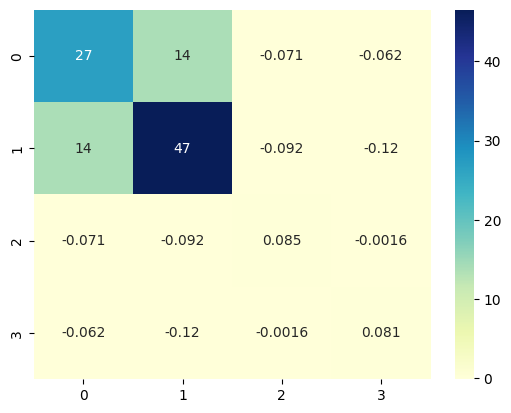

In [3]:
cov_mat = np.cov(X, rowvar = False) # occorre la trasposta
import seaborn as sns
sns.heatmap(cov_mat, cmap="YlGnBu", annot=True);

### 2. Inspect

In [4]:
print(f'There are {X.shape[0]} samples and {X.shape[1]} features')

There are 1500 samples and 4 features


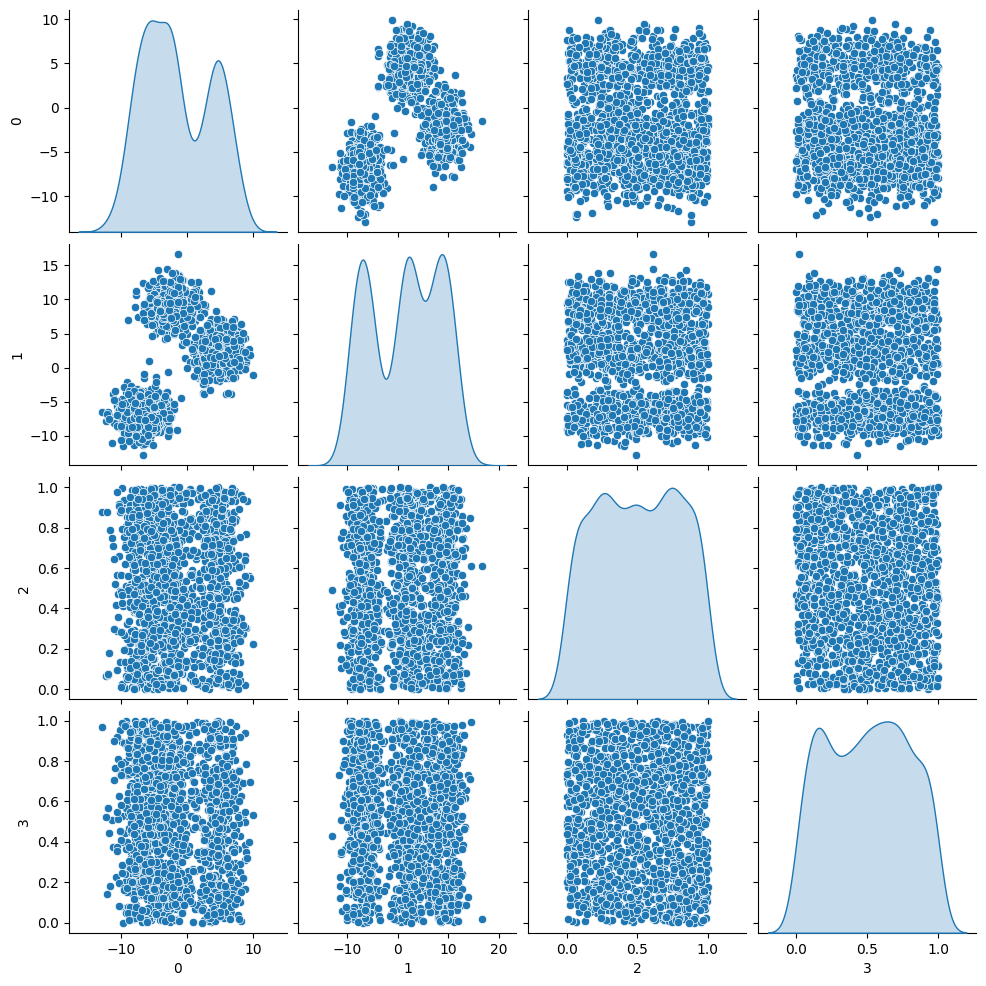

In [5]:
sns.pairplot(pd.DataFrame(X), diag_kind="kde");

In [6]:
X = X[:,[0,1]]
focus = [0,1]
# focus = [0,2]

### 3. Observing the pairplots
In this simple example you can easily see which are the two most interesting columns.

All the plots will focus on those columns

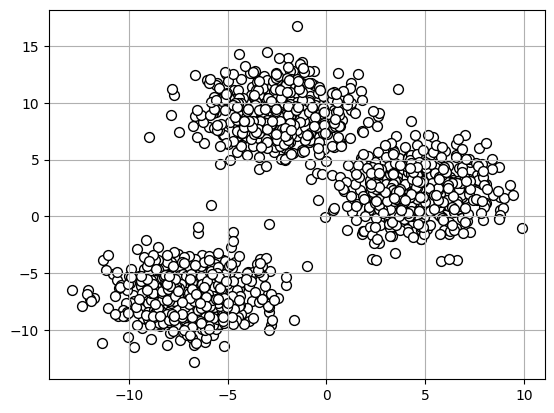

In [7]:
plt.scatter(X[:,focus[0]], X[:,focus[1]]
            , c='white'          # color filling the data markers
            , edgecolors='black' # edge color for data markers
            , marker='o'         # data marker shape, e.g. triangles (v<>^), square (s), star (*), ...
            , s=50)              # data marker size
plt.grid()  # plots a grid on the data
plt.show()

### 4. Initialize, fit_predict and plot the clusters

In [8]:
db = DBSCAN()
y_db = db.fit_predict(X)

In [9]:
db.eps, db.min_samples

(0.5, 5)

In [10]:
cluster_labels_all = np.unique(y_db)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
if cluster_labels_all[0] == -1:
    noise = True
    print("There is noise")
else:
    noise = False
print("There is/are {} cluster(s)".format(n_clusters-noise))

There is noise
There is/are 11 cluster(s)


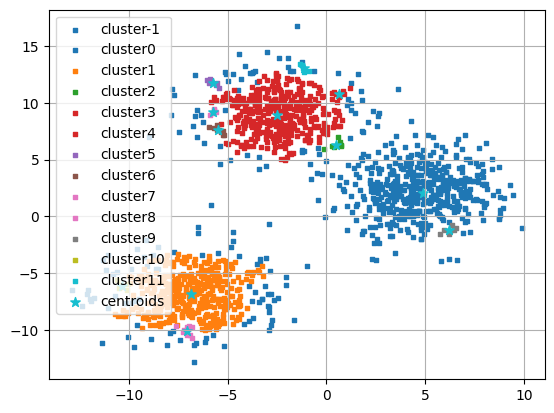

In [11]:
cluster_centers = np.empty((n_clusters,X.shape[1]))
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X[y_db==i,:], axis = 0)
plot_clusters(X,y_db,dim=(focus[0],focus[1]), points = cluster_centers)

### 5. Find the best parameters using `ParameterGrid`

In [12]:
param_grid = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(1,10,1))}
params = list(ParameterGrid(param_grid))

Arrange DBSCAN results in a dataframe, for easier presentation and filtering

In [13]:
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if n_clusters > 1:
        X_cl = X[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

In [14]:
sil_thr = 0.7  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
n_clu_max_thr = 4
dbscan_out[
    (dbscan_out['silhouette'] > sil_thr) &
    (dbscan_out['unclust%'] < unc_thr) &
    (dbscan_out['n_clusters'] <= n_clu_max_thr)
]

,eps,min_samples,n_clusters,silhouette,unclust%
542,0.72,6.0,3.0,0.719631,7.866667
551,0.73,6.0,3.0,0.719266,7.666667
560,0.74,6.0,3.0,0.719029,7.466667
569,0.75,6.0,3.0,0.718215,7.266667
578,0.76,6.0,3.0,0.717239,7.066667
...,...,...,...,...,...
778,0.98,8.0,3.0,0.708884,4.533333
779,0.98,9.0,3.0,0.709335,4.600000
786,0.99,7.0,3.0,0.705171,4.000000
787,0.99,8.0,3.0,0.707730,4.400000


### 6. Observe  
- Observe visually the most promising combination of parameters.  
- Plot the clusters with the centers  
- Plot the silhouette indexs for all the clustered samples  

In [15]:
db = DBSCAN(eps = 0.99, min_samples = 9)
y_db = db.fit_predict(X)
cluster_labels_all = np.unique(y_db)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

In [16]:
cluster_centers = np.empty((n_clusters,X.shape[1]))
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X[y_db==i,:], axis = 0)

In [18]:
print(f'There are {n_clusters} clusters')

There are 3 clusters


In [19]:
print(f'The cluster labels are {cluster_labels}')

The cluster labels are [0 1 2]


In [ ]:
# from plot_silhouette import plot_silhouette  # python script provided separately
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately
plot_silhouette(silhouette,y_db)

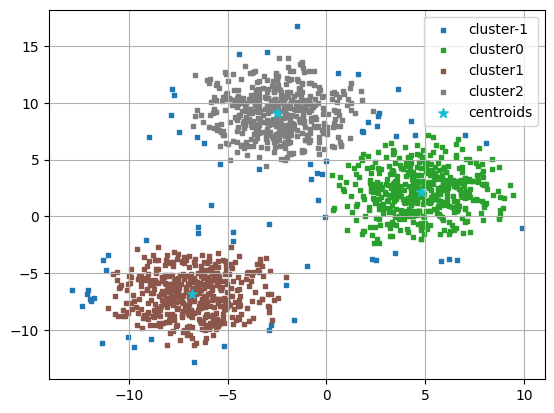

In [20]:
plot_clusters(X,y_db,dim=(focus[0],focus[1]), points = cluster_centers)

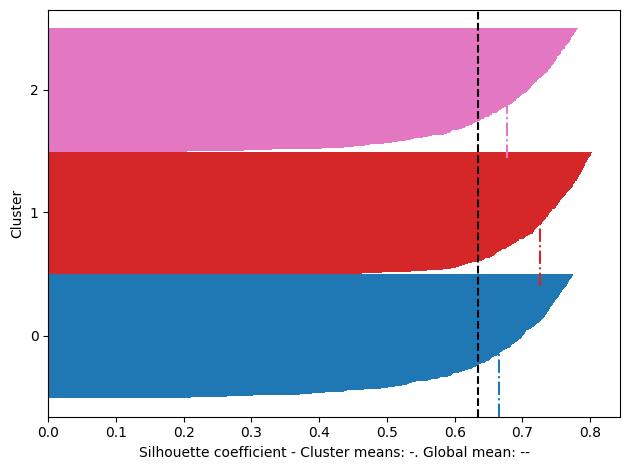

In [21]:
silhouette = silhouette_samples(X,y_db)
from plot_silhouette_w_mean import plot_silhouette 
plot_silhouette(silhouette,y_db)

A quick look to the width of data ranges

In [23]:
np.max(X, axis=0)-np.min(X,axis=0)

array([22.84721703, 29.58213064])

In [24]:
mms = MinMaxScaler()
Xs = mms.fit_transform(X)

In [25]:
Xs.max(axis=0)-Xs.min(axis=0)

array([1., 1.])